# GUI (Gradio)

In [15]:
import gradio as gr
import tensorflow as tf
import numpy as np
import cv2

# Function to draw bounding boxes on the image
def draw_boxes(image, detections):
    image_with_boxes = np.copy(image)
    image_height, image_width, _ = image.shape
    
    # Process the detection results and draw bounding boxes
    for detection in detections:
        # Extract the bounding box coordinates and class label
        box = detection['box']
        class_label = detection['class_label']
        
        # Scale the bounding box coordinates
        start_x = int(box[1] * image_width)
        start_y = int(box[0] * image_height)
        end_x = int(box[3] * image_width)
        end_y = int(box[2] * image_height)
        
        # Draw the bounding box rectangle on the image
        cv2.rectangle(image_with_boxes, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
        
        # Add the class label text
        label_text = f'{class_label}'
        label_size, _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        text_width, text_height = label_size
        cv2.rectangle(image_with_boxes, (start_x, start_y - text_height - 5),
                      (start_x + text_width + 5, start_y), (0, 255, 0), -1)
        cv2.putText(image_with_boxes, label_text, (start_x + 2, start_y - 2),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
    
    return image_with_boxes

# Define input size for the model
input_width = 640
input_height = 480

# Create the Gradio interface
iface = gr.Interface(
    fn=recognize_image,
    inputs="image",
    outputs="image",
    title="Object Detection",
    description="Detect objects in an image.",
    allow_flagging=False
)

# Launch the interface
iface.launch()

C:\Users\SAURAV\anaconda3\lib\site-packages\gradio\interface.py:325: UserWarning: The `allow_flagging` parameter in `Interface` nowtakes a string value ('auto', 'manual', or 'never'), not a boolean. Setting parameter to: 'never'.
  warnings.warn(


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "C:\Users\SAURAV\anaconda3\lib\site-packages\gradio\routes.py", line 427, in run_predict
    output = await app.get_blocks().process_api(
  File "C:\Users\SAURAV\anaconda3\lib\site-packages\gradio\blocks.py", line 1323, in process_api
    result = await self.call_function(
  File "C:\Users\SAURAV\anaconda3\lib\site-packages\gradio\blocks.py", line 1051, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "C:\Users\SAURAV\anaconda3\lib\site-packages\anyio\to_thread.py", line 28, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(func, *args, cancellable=cancellable,
  File "C:\Users\SAURAV\anaconda3\lib\site-packages\anyio\_backends\_asyncio.py", line 818, in run_sync_in_worker_thread
    return await future
  File "C:\Users\SAURAV\anaconda3\lib\site-packages\anyio\_backends\_asyncio.py", line 754, in run
    result = context.run(func, *args)
  File "C:\Users\SAURAV\AppData\Local\Temp\ipykernel_15584\24891

## 0. Install and Import Dependencies

In [1]:
!pip install easyocr
!pip install imutils

In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

## 1. Read in Image, Grayscale and Blur

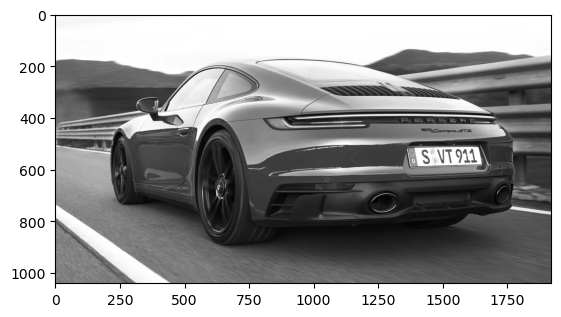

In [3]:
img = cv2.imread('image5.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

## 2. Apply filter and find edges for localization

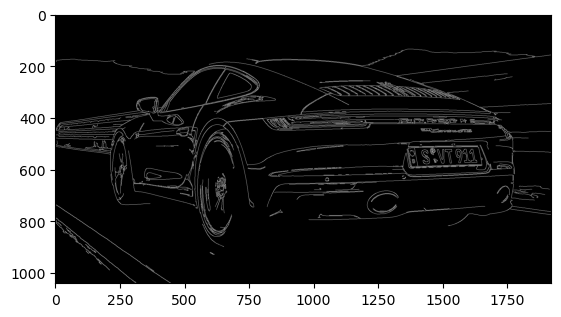

In [4]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
edged = cv2.Canny(bfilter, 30, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

## 3. Find Contours and Apply Mask

In [5]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [6]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

In [7]:
location

array([[[1652,  576]],

       [[1405,  588]],

       [[1391,  518]],

       [[1635,  513]]], dtype=int32)

In [8]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

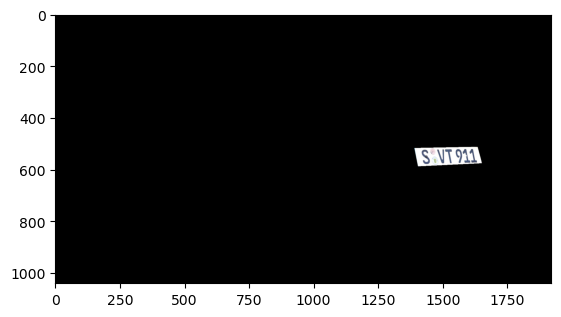

In [9]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [10]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

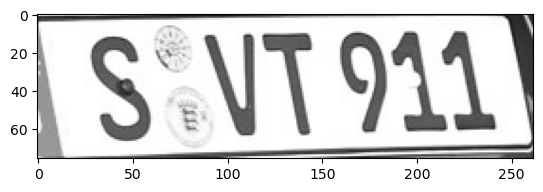

In [11]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

## 4. Use Easy OCR To Read Text

In [12]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[0, 0], [250, 0], [250, 74], [0, 74]], 'TS VT911', 0.17057720149688216)]

## 5. Render Result

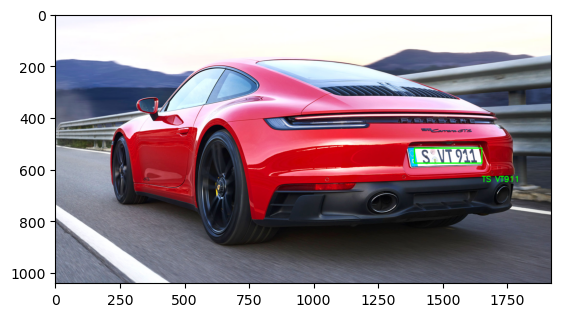

In [13]:
text = result[0][-2]
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))